You are given a dataset that consists of approximately 3000 customer reviews (input text), ratings, date of the review (see ex5 file). You need to build a model to predict the sentiment of the review (positive or negative). We consider ratings 4 and 5 as a positive review, all other ratings are negative. Please include your work in the Jupyter notebook with the analysis of this data, training and testing of the model. Also, at the end of your analysis, could you briefly describe the steps you would take in order to release the model on production.

In [23]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize 
from nltk.corpus import wordnet

%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')

In [24]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def to_vw_format(text, numeric, categorical, label=None):
    """Transform our data to Vowpal Wabbit format"""
    return str(label or '') + ' |num ' + ' '.join(numeric) + \
            ' |cat ' + ' '.join(categorical) + ' |text ' + \
            ' '.join(re.findall('\w{3,}', text.lower())) + '\n'


def to_vw_format_simple(text, label=None):
    """Transform our data to Vowpal Wabbit format"""
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', text.lower())) + '\n'

In [25]:
train = pd.read_csv('data/ex5.csv')

In [26]:
train.head()

,rating,date,verified_reviews,feedback
0,5,31-Jul-18,Love my Echo!,1
1,5,31-Jul-18,Loved it!,1
2,4,31-Jul-18,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Music,1


In [27]:
train['date'].unique()

array(['31-Jul-18', '30-Jul-18', '29-Jul-18', '28-Jul-18', '27-Jul-18',
       '26-Jul-18', '25-Jul-18', '24-Jul-18', '23-Jul-18', '22-Jul-18',
       '21-Jul-18', '20-Jul-18', '19-Jul-18', '18-Jul-18', '17-Jul-18',
       '16-Jul-18', '15-Jul-18', '14-Jul-18', '13-Jul-18', '12-Jul-18',
       '11-Jul-18', '10-Jul-18', '9-Jul-18', '8-Jul-18', '7-Jul-18',
       '6-Jul-18', '5-Jul-18', '4-Jul-18', '3-Jul-18', '2-Jul-18',
       '1-Jul-18', '30-Jun-18', '29-Jun-18', '28-Jun-18', '27-Jun-18',
       '26-Jun-18', '25-Jun-18', '24-Jun-18', '23-Jun-18', '22-Jun-18',
       '21-Jun-18', '20-Jun-18', '19-Jun-18', '18-Jun-18', '17-Jun-18',
       '16-Jun-18', '15-Jun-18', '14-Jun-18', '13-Jun-18', '12-Jun-18',
       '11-Jun-18', '10-Jun-18', '9-Jun-18', '8-Jun-18', '7-Jun-18',
       '6-Jun-18', '5-Jun-18', '4-Jun-18', '3-Jun-18', '2-Jun-18',
       '1-Jun-18', '31-May-18', '30-May-18', '29-May-18', '28-May-18',
       '27-May-18', '26-May-18', '25-May-18', '24-May-18', '23-May-18',
       '22

In [28]:
train[train['feedback'] == 0].describe()

,rating,feedback
count,257.000000,257.0
mean,1.373541,0.0
std,0.484688,0.0
min,1.000000,0.0
25%,1.000000,0.0
50%,1.000000,0.0
75%,2.000000,0.0
max,2.000000,0.0


In [29]:
train[train['feedback'] == 1].describe()

,rating,feedback
count,2893.000000,2893.0
mean,4.737643,1.0
std,0.546544,0.0
min,3.000000,1.0
25%,5.000000,1.0
50%,5.000000,1.0
75%,5.000000,1.0
max,5.000000,1.0


### Base model

Let's build a base model in where we will analyze only the text without preprocessing, without any additional features.

In [30]:
train.drop(columns=['date', 'feedback'], inplace=True)
train.head()

,rating,verified_reviews
0,5,Love my Echo!
1,5,Loved it!
2,4,"Sometimes while playing a game, you can answer..."
3,5,I have had a lot of fun with this thing. My 4 ...
4,5,Music


To build the model we will use the library Vowpal Wabbit.  With the hashing trick implemented, Vowpal Wabbit is a perfect choice for working with text data. It is prominent for its training speed and support of many training modes, especially for online learning with big and high-dimentional data.

We split our data into train and test and write these into separate files and convert the data into something Vowpal Wabbit can understand. We will throw away words shorter than 3 symbols.

In [31]:
all_reviews = train['verified_reviews']
all_targets = [1 if train['rating'][i] > 3
               else -1 for i in range(len(train['rating']))]

train_reviews, test_reviews, train_labels, test_labels = \
    train_test_split(all_reviews, all_targets, random_state=42)

with open('data/reviews/train.vw', 'w') as vw_train_data:
    for text, target in zip(train_reviews, train_labels):
        vw_train_data.write(to_vw_format_simple(text, target))

with open('data/reviews/test.vw', 'w') as vw_test_data:
    for text in test_reviews:
        vw_test_data.write(to_vw_format_simple(text))

Pass the created training file to Vowpal Wabbit. We solve the classification problem with a logistic loss function  and bigrams because it showed better result after trials with different args. Also we add a coefficient in front of class 1 because our classes are imbalanced.

In [32]:
!vw -d data/reviews/train.vw \
  --loss_function logistic --ngram 2 --classweight 1:0.25 \
    -f data/reviews/train_model.vw --quiet

Use our model to make predictions

In [33]:
!vw -i data/reviews/train_model.vw -t -d data/reviews/test.vw \
-p data/reviews/test_predictions.txt --quiet

And now we load our predictions, compute AUC, and plot the ROC curve:

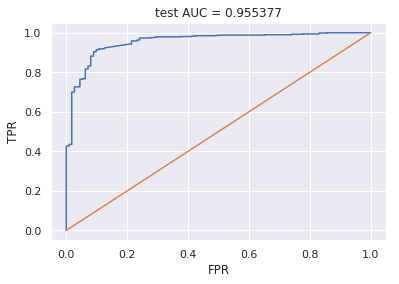

In [34]:
with open('data/reviews/test_predictions.txt') as pred_file:
    test_prediction = [float(label)
                       for label in pred_file.readlines()]

auc = roc_auc_score(test_labels, test_prediction)
rocCurve = roc_curve(test_labels, test_prediction)


plt.plot(rocCurve[0], rocCurve[1])
plt.plot([0, 1], [0, 1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('test AUC = %f' % (auc))
plt.axis([-0.05, 1.05, -0.05, 1.05])

In [35]:
print('AUC for base model with only text and bigrams: ', 
      round(roc_auc_score(test_labels, test_prediction), 3))

AUC for base model with only text and bigrams:  0.955


### Model with lemmatization

Let's try to improve our result by using lemmatization

In [36]:
lemmatizer = WordNetLemmatizer()

all_reviews_lem = train['verified_reviews']

for i in range(len(all_reviews_lem)):
    all_reviews_lem[i] = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w))
                                   for w in nltk.word_tokenize(all_reviews_lem[i])])

In [37]:
train_reviews, test_reviews, train_labels, test_labels = \
    train_test_split(all_reviews_lem, all_targets, random_state=42)

with open('data/reviews/train.vw', 'w') as vw_train_data:
    for text, target in zip(train_reviews, train_labels):
        vw_train_data.write(to_vw_format_simple(text, target))

with open('data/reviews/test.vw', 'w') as vw_test_data:
    for text in test_reviews:
        vw_test_data.write(to_vw_format_simple(text))

In [38]:
!vw -d data/reviews/train.vw \
  --loss_function logistic --ngram 2 --classweight 1:0.25 \
    -f data/reviews/train_model.vw --quiet

In [39]:
!vw -i data/reviews/train_model.vw -t -d data/reviews/test.vw \
-p data/reviews/test_predictions.txt --quiet

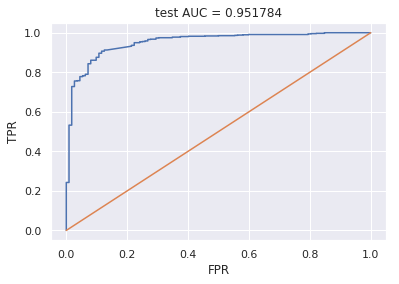

In [40]:
with open('data/reviews/test_predictions.txt') as pred_file:
    test_prediction = [float(label)
                       for label in pred_file.readlines()]

auc = roc_auc_score(test_labels, test_prediction)
rocCurve = roc_curve(test_labels, test_prediction)


plt.plot(rocCurve[0], rocCurve[1])
plt.plot([0, 1], [0, 1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('test AUC = %f' % (auc))
plt.axis([-0.05, 1.05, -0.05, 1.05])

In [41]:
print('AUC for base model with only text and bigrams: ',
      round(roc_auc_score(test_labels, test_prediction), 3))

AUC for base model with only text and bigrams:  0.952


### Model with additional features without lemmatization and stop words

Let's try to use the other features to improve the result.

Divide the date into a year, month and week, and allocate the day of the week. We have data for a relatively short period of time - 3 months, but since we will use the model in the future, new information can help in the task at hand, even if it has little impact on the result now.

In [42]:
train = pd.read_csv('data/ex5.csv')

train['date'] = pd.to_datetime(train['date'])

train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['dayOfMonth'] = train['date'].dt.day
train['dayOfWeek'] = train['date'].dt.dayofweek

train.drop(columns='date', inplace=True)

train.head()

,rating,verified_reviews,feedback,year,month,dayOfMonth,dayOfWeek
0,5,Love my Echo!,1,2018,7,31,1
1,5,Loved it!,1,2018,7,31,1
2,4,"Sometimes while playing a game, you can answer...",1,2018,7,31,1
3,5,I have had a lot of fun with this thing. My 4 ...,1,2018,7,31,1
4,5,Music,1,2018,7,31,1


In [43]:
all_reviews = train['verified_reviews']
all_targets = [1 if train['rating'][i] > 3
               else -1 for i in range(len(train['rating']))]

all_numeric = train[['feedback', 'year']]
all_categorical = train[['month', 'dayOfMonth', 'dayOfWeek']]

Encode different types of data for vw library in the appropriate way. We can deal with month and day of the month in different ways. If we use them as a real variable, we slightly contradict the nature of data: 1<31 while 01.02 > 31.01. At the same time, if we encode them as categorical variables, we'll breed a large numbers of features and lose information about proximity - the difference between 29 and 30 will be the same as the difference between 1 and 15.
However, the difference between such coding methods is down to the third decimal place in the metric in our task.

In [44]:
for col in all_numeric:
    all_numeric[col] = all_numeric[col].apply(
        lambda x: col + ':' + str(x))

for col in all_categorical:
    all_categorical[col] = all_categorical[col].apply(
        lambda x: col + '=' + str(x))

In [45]:
all_numeric.head()

,feedback,year
0,feedback:1,year:2018
1,feedback:1,year:2018
2,feedback:1,year:2018
3,feedback:1,year:2018
4,feedback:1,year:2018


In [46]:
all_categorical.head()

,month,dayOfMonth,dayOfWeek
0,month=7,dayOfMonth=31,dayOfWeek=1
1,month=7,dayOfMonth=31,dayOfWeek=1
2,month=7,dayOfMonth=31,dayOfWeek=1
3,month=7,dayOfMonth=31,dayOfWeek=1
4,month=7,dayOfMonth=31,dayOfWeek=1


In [47]:
train_reviews, test_reviews, \
train_num, test_num, \
train_cat, test_cat, \
train_labels, test_labels = train_test_split(all_reviews, all_numeric, 
                                             all_categorical, all_targets, 
                                             random_state=42)

with open('data/reviews/train.vw', 'w') as vw_train_data:
    for text, numeric, categorical, target in zip(train_reviews, 
                                                  train_num.values, 
                                                  train_cat.values, 
                                                  train_labels):
        vw_train_data.write(to_vw_format(text, 
                                         train_num, 
                                         train_cat, 
                                         target))

with open('data/reviews/test.vw', 'w') as vw_test_data:
    for text, numeric, categorical in zip(test_reviews, 
                                          test_num.values, 
                                          test_cat.values,):
        vw_test_data.write(to_vw_format(text, 
                                        test_num, 
                                        test_cat))

In [48]:
!vw -d data/reviews/train.vw \
  --loss_function logistic --ngram 2 --classweight 1:0.25 \
    -f data/reviews/train_model.vw --quiet

In [49]:
!vw -i data/reviews/train_model.vw -t -d data/reviews/test.vw \
-p data/reviews/test_predictions.txt --quiet

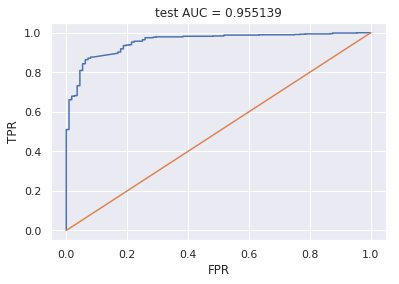

In [50]:
with open('data/reviews/test_predictions.txt') as pred_file:
    test_prediction = [float(label)
                       for label in pred_file.readlines()]

auc = roc_auc_score(test_labels, test_prediction)
rocCurve = roc_curve(test_labels, test_prediction)


plt.plot(rocCurve[0], rocCurve[1])
plt.plot([0, 1], [0, 1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('test AUC = %f' % (auc))
plt.axis([-0.05, 1.05, -0.05, 1.05])

In [51]:
print('AUC for base model with only text and bigrams: ', 
      round(roc_auc_score(test_labels, test_prediction), 3))

AUC for base model with only text and bigrams:  0.955


### Model with additional features and with lemmatization

In [52]:
train = pd.read_csv('data/ex5.csv')

train['date'] = pd.to_datetime(train['date'])

train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['dayOfMonth'] = train['date'].dt.day
train['dayOfWeek'] = train['date'].dt.dayofweek

train.drop(columns='date', inplace=True)

train.head()

,rating,verified_reviews,feedback,year,month,dayOfMonth,dayOfWeek
0,5,Love my Echo!,1,2018,7,31,1
1,5,Loved it!,1,2018,7,31,1
2,4,"Sometimes while playing a game, you can answer...",1,2018,7,31,1
3,5,I have had a lot of fun with this thing. My 4 ...,1,2018,7,31,1
4,5,Music,1,2018,7,31,1


In [53]:
all_reviews = train['verified_reviews']
all_targets = [1 if train['rating'][i] > 3
               else -1 for i in range(len(train['rating']))]

all_numeric = train[['feedback', 'year']]
all_categorical = train[['month', 'dayOfMonth', 'dayOfWeek']]

In [54]:
for col in all_numeric:
    all_numeric[col] = all_numeric[col].apply(
        lambda x: col + ':' + str(x))

for col in all_categorical:
    all_categorical[col] = all_categorical[col].apply(
        lambda x: col + '=' + str(x))

In [55]:
train_reviews, test_reviews, \
train_num, test_num, \
train_cat, test_cat, \
train_labels, test_labels = train_test_split(all_reviews_lem, 
                                             all_numeric, 
                                             all_categorical, 
                                             all_targets, 
                                             random_state=42)

with open('data/reviews/train.vw', 'w') as vw_train_data:
    for text, numeric, categorical, target in zip(train_reviews, 
                                                  train_num.values, 
                                                  train_cat.values, 
                                                  train_labels):
        vw_train_data.write(to_vw_format(text, 
                                         train_num, 
                                         train_cat, 
                                         target))
        
with open('data/reviews/test.vw', 'w') as vw_test_data:
    for text, numeric, categorical in zip(test_reviews, 
                                          test_num.values, 
                                          test_cat.values,):
        vw_test_data.write(to_vw_format(text, 
                                        test_num, 
                                        test_cat))

In [56]:
!vw -d data/reviews/train.vw \
  --loss_function logistic --ngram 2 --classweight 1:0.25 \
    -f data/reviews/train_model.vw --quiet

In [57]:
!vw -i data/reviews/train_model.vw -t -d data/reviews/test.vw \
-p data/reviews/test_predictions.txt --quiet

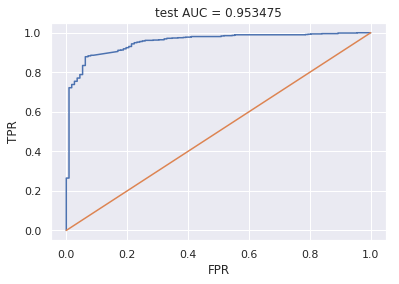

In [58]:
with open('data/reviews/test_predictions.txt') as pred_file:
    test_prediction = [float(label)
                       for label in pred_file.readlines()]

auc = roc_auc_score(test_labels, test_prediction)
rocCurve = roc_curve(test_labels, test_prediction)


plt.plot(rocCurve[0], rocCurve[1])
plt.plot([0, 1], [0, 1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('test AUC = %f' % (auc))
plt.axis([-0.05, 1.05, -0.05, 1.05])

In [59]:
print('AUC for base model with only text and bigrams: ', 
      round(roc_auc_score(test_labels, test_prediction), 3))

AUC for base model with only text and bigrams:  0.953


**Results (AUC score):**
1. Base model (only text without any preprocessing)                     : 0.955 
2. Base model with lemmatization                         : 0.952
3. Model with additional features (without lemmatization): 0.955
4. Model with additional features and with lemmatization: 0.953

As we can see, our base model gives the same result as the model with additional features, and even better in the fourth decimal point. But with a longer data period, additional information about the date can play a role. Also, the model with the preprocessing of the text showed a worse result than without it.  